In [6]:
import pandas as pd
import numpy as np
import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import lightgbm as lgb
from catboost import CatBoostClassifier

from boruta import BorutaPy

def evaluate_model(model_name, model, X, y):
    
    predictions_probas = model.predict_proba(X)[:,1]
    predictions = model.predict(X)

    Accuracy = accuracy_score(y, predictions)
    AUC = roc_auc_score(y, predictions_probas)
    LogLoss = log_loss(y, predictions_probas)

    print('Accuracy for', model_name, ': %1.3f' % Accuracy)
    print('AUC for', model_name, ': %1.4f' % AUC)
    print('LogLoss for', model_name, ': %1.3f' % LogLoss)
    
    
def plot_fpr_fnr(model, model_name, x, y):
    
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x)[:,1])
    fnr = 1 - tpr

    plt.figure(figsize = (9, 4))
    sns.lineplot(thresholds, fpr, label = 'FPR')
    sns.lineplot(thresholds, fnr, label = 'FNR')
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1.01, 0.05), fontsize = 8)
    plt.yticks(np.arange(0, 1.01, 0.1), fontsize = 8)
    plt.title('FPR and FNR plots for ' + model_name + '\n')
    plt.xlabel('Thresholds')
    plt.ylabel('Rates')
    plt.grid(linestyle = "--", color = 'black', alpha = 1/3, linewidth = 1/2)
    plt.show()
    
    
def plot_roc_auc(model, model_name, x, y):
    
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x)[:,1])
    
    plt.figure(figsize = (9, 4))
    sns.lineplot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc(fpr, tpr))
    sns.lineplot([0, 1], [0, 1], color = 'black')
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1.01, 0.05), fontsize = 8)
    plt.yticks(np.arange(0, 1.01, 0.1), fontsize = 8)
    plt.title('ROC curve and AUC for ' + model_name + '\n')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(linestyle = "--", color = 'black', alpha = 1/3, linewidth = 1/2)
    plt.show()
    
    
def print_confusion_matrix(model, model_name, threshold, x, y):
    
    predictions = (model.predict_proba(x)[:,1] > threshold).astype(int)

    unnormalized_confusion_matrix = pd.DataFrame(confusion_matrix(y, predictions, normalize = None), 
                 columns = pd.MultiIndex.from_tuples([('PREDICTED', 'negative'), ('PREDICTED', 'positive')]),
                 index = pd.MultiIndex.from_tuples([('TRUE', 'negative'), ('TRUE', 'positive')]))

    normalized_confusion_matrix = pd.DataFrame(confusion_matrix(y, predictions, normalize = 'true'), 
                 columns = pd.MultiIndex.from_tuples([('PREDICTED', 'negative'), ('PREDICTED', 'positive')]),
                 index = pd.MultiIndex.from_tuples([('TRUE', 'negative'), ('TRUE', 'positive')]))
    
    print('Confusion matrices for', model_name, 'at threshold', threshold, '\n')

    print(unnormalized_confusion_matrix)
    print('\n')
    print(normalized_confusion_matrix)
    
def plot_roc_auc_without_model(model_name, x, y):
    
    fpr, tpr, thresholds = roc_curve(y, x)
    
    plt.figure(figsize = (9, 4))
    sns.lineplot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc(fpr, tpr))
    sns.lineplot([0, 1], [0, 1], color = 'black')
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1.01, 0.05), fontsize = 8)
    plt.yticks(np.arange(0, 1.01, 0.1), fontsize = 8)
    plt.title('ROC curve and AUC for ' + model_name + '\n')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(linestyle = "--", color = 'black', alpha = 1/3, linewidth = 1/2)
    plt.show()
    

import warnings
warnings.filterwarnings('ignore')

### Train test split

In [7]:
data = pd.read_csv('../data/scraped_for_modeling_labeled.csv')
data.fillna(0, inplace = True) # divisions with 0
data.head(3)

,Team,offense_points_per_game,season,games_played,offense_downs_Third Downs_PCT,offense_downs_Fourth Downs_PCT,offense_passing_CMP%,offense_passing_AVG,offense_passing_YDS/G,offense_passing_RTG,...,offense_receiving_FUM_per_game,offense_rushing_FUM_per_game,defense_receiving_FUM_per_game,defense_rushing_FUM_per_game,offense_receiving_LST_FUM_ratio,offense_rushing_LST_FUM_ratio,defense_receiving_LST_FUM_ratio,defense_rushing_LST_FUM_ratio,winner,played
0,Kansas City Chiefs,30.2,2004,16,47.2,28.6,66.0,8.3,275.4,94.9,...,0.1250,0.4375,0.4375,0.5625,1.00,0.571429,0.428571,0.444444,0,0
1,Indianapolis Colts,32.6,2004,16,42.7,57.1,67.0,9.0,288.9,119.7,...,0.2500,0.5625,0.3750,0.6250,0.75,0.444444,0.666667,0.400000,0,0
2,Green Bay Packers,26.5,2004,16,47.3,57.1,63.9,7.6,278.1,93.9,...,0.3125,0.5625,0.1875,0.3125,0.60,0.666667,0.666667,0.400000,0,0


In [8]:
X = data.drop(['winner', 'played'], 1).copy()
y = data['played'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .85, random_state = 20202020)

print(X_train.shape)
print(y_train.shape)

(462, 66)
(462,)


### Eliminate some features using BorutaPy

For play prediction

In [9]:
forest = RandomForestClassifier(max_depth = 7, max_features = 10, n_jobs = -1)
boruta = BorutaPy(estimator = forest, n_estimators = 250, perc = 75, max_iter = 200, random_state = 20202020)
boruta.fit(np.array(X_train.drop(['Team', 'games_played', 'season'], 1)), 
           np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(max_depth=7, max_features=10,
                                          n_estimators=250, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x273D479D240),
         max_iter=200, n_estimators=250, perc=75,
         random_state=RandomState(MT19937) at 0x273D479D240)

In [10]:
to_keep = X_train.drop(['Team', 'games_played', 'season'], 1).columns[boruta.support_].to_list()
print('Boruta suggests keeping', len(to_keep), 'features out of ', 
      X_train.drop(['Team', 'games_played', 'season'], 1).shape[1], ':', to_keep)

Boruta suggests keeping 18 features out of  63 : ['offense_points_per_game', 'offense_passing_AVG', 'offense_passing_YDS/G', 'offense_passing_RTG', 'offense_receiving_AVG', 'offense_rushing_YDS/G', 'defense_points_per_game', 'defense_passing_AVG', 'defense_receiving_AVG', 'defense_rushing_YDS/G', 'defense_passing_SYL_per_game', 'offense_downs_Third Downs_ATT_per_game', 'defense_downs_Third Downs_ATT_per_game', 'defense_downs_Fourth Downs_ATT_per_game', 'defense_pass_to_rush_ratio', 'defense_downs_First Downs_penalty_ratio', 'offense_passing_TD_per_game', 'offense_pass_TD_to_INT']


Drop unimportant features

In [13]:
X_train_reduced = X_train[['Team', 'games_played', 'season'] + to_keep].copy()
X_test_reduced = X_test[['Team', 'games_played', 'season'] + to_keep].copy()

## Start modeling probability of playing in the Super Bowl
### 1. Random Forest
#### A. All features

In [ ]:
start = time.time()
print("Started at", str(time.ctime(int(start))))

RF_params = {'criterion' : ['gini'],
             'max_depth' : [5, 7],
             'min_samples_split' : [3],
             'min_samples_leaf' : [13, 15, 17],
             'max_features' : [.4, .5],
             'n_estimators' : [100, 150]}

RF = RandomForestClassifier(random_state = 20202020)

GRID_RF = GridSearchCV(RF, param_grid = RF_params, cv = 3, scoring = 'roc_auc', n_jobs = -1)
GRID_RF.fit(X_train.drop(['Team', 'games_played', 'season'], 1), y_train)

print("Ended at", str(time.ctime(int(time.time()))))
print(time.time() - start)

In [17]:
rf_results = evaluate_model('RandomForest', GRID_RF.best_estimator_, 
                            X_test.drop(['Team', 'games_played', 'season'], 1), y_test)

Accuracy for RandomForest : 0.951
AUC for RandomForest : 0.8558
LogLoss for RandomForest : 0.155


In [ ]:
plot_roc_auc(GRID_RF.best_estimator_, 'Random Forest', 
             X_test.drop(['Team', 'games_played', 'season'], 1), y_test)

In [ ]:
plot_fpr_fnr(GRID_RF.best_estimator_, 'Random Forest', 
             X_test.drop(['Team', 'games_played', 'season'], 1), y_test)

In [ ]:
print_confusion_matrix(GRID_RF.best_estimator_, 'Random Forest', 0.09,                           
             X_test.drop(['Team', 'games_played', 'season'], 1), y_test)

#### B. Boruta reduced features

In [63]:
start = time.time()
print("Started at", str(time.ctime(int(start))))

RF_params = {'criterion' : ['gini'],
             'max_depth' : [11],
             'min_samples_split' : [3],
             'min_samples_leaf' : [19],
             'max_features' : [.5],
             'n_estimators' : [100]}

RF = RandomForestClassifier(random_state = 20202020)

GRID_RF_reduced = GridSearchCV(RF, param_grid = RF_params, cv = 3, scoring = 'roc_auc', n_jobs = -1)
GRID_RF_reduced.fit(X_train_reduced.drop(['Team', 'games_played', 'season'], 1), y_train)

print("Ended at", str(time.ctime(int(time.time()))))
print(time.time() - start)

Started at Wed Sep 15 21:12:35 2021
Ended at Wed Sep 15 21:12:35 2021
0.7095339298248291


In [64]:
rf_results = evaluate_model('RandomForest', GRID_RF_reduced.best_estimator_, 
                            X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

Accuracy for RandomForest : 0.951
AUC for RandomForest : 0.8365
LogLoss for RandomForest : 0.162


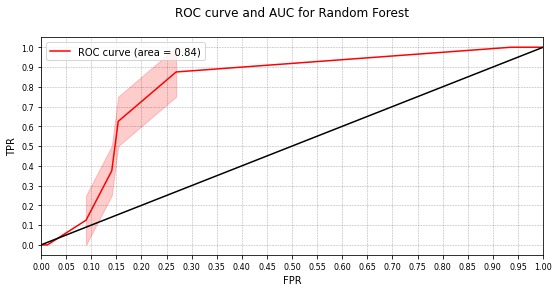

In [31]:
plot_roc_auc(GRID_RF_reduced.best_estimator_, 'Random Forest', 
             X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

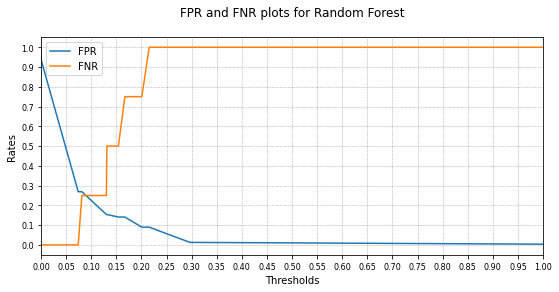

In [32]:
plot_fpr_fnr(GRID_RF_reduced.best_estimator_, 'Random Forest', 
             X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

In [33]:
print_confusion_matrix(GRID_RF_reduced.best_estimator_, 'Random Forest', 0.1,                           
             X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

Confusion matrices for Random Forest at threshold 0.1 

              PREDICTED         
               negative positive
TRUE negative        60       18
     positive         1        3


              PREDICTED          
               negative  positive
TRUE negative  0.769231  0.230769
     positive  0.250000  0.750000


Boruta is working well: the model with just 19 features performs almost as well as the one with 61 features

In [34]:
pkl_filename = '../modeling/rf.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(GRID_RF_reduced.best_estimator_, file)

### 2. GBM (sklearn)

In [57]:
start = time.time()
print("Started at", str(time.ctime(int(start))))

GBM_params = {'learning_rate' : [0.01],
              'subsample' : [.8],
              'max_features' : [.4],
              'max_depth' : [9],
              'min_samples_split' : [3],
              'min_samples_leaf' : [19],
              'n_estimators' : [100]}

GBM = GradientBoostingClassifier(random_state = 20202020)

GRID_GBM = GridSearchCV(GBM, param_grid = GBM_params, cv = 3, scoring = 'roc_auc', n_jobs = -1)
GRID_GBM.fit(X_train_reduced.drop(['Team', 'games_played', 'season'], 1), y_train)

print("Ended at", str(time.ctime(int(time.time()))))
print(time.time() - start)

Started at Wed Sep 15 21:12:10 2021
Ended at Wed Sep 15 21:12:11 2021
0.4777340888977051


In [58]:
gbm_results = evaluate_model('GradientBoosting', GRID_GBM.best_estimator_, 
                            X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

Accuracy for GradientBoosting : 0.951
AUC for GradientBoosting : 0.8622
LogLoss for GradientBoosting : 0.172


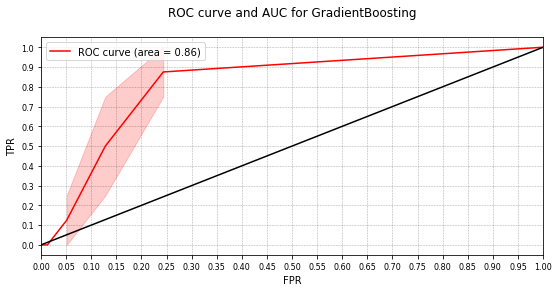

In [59]:
plot_roc_auc(GRID_GBM.best_estimator_, 'GradientBoosting', 
             X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

In [60]:
pkl_filename = '../modeling/gbm.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(GRID_GBM.best_estimator_, file)

### 3. LightGBM

In [140]:
start = time.time()
print("Started at", str(time.ctime(int(start))))

LGB_params = {'boosting_type' : ['dart', 'goss'],
              'learning_rate' : [0.05],
              'num_leaves' : [5],
              'min_child_samples' : [7],
              'max_depth' : [5],
              'colsample_bytree' : [0.4],
              'n_estimators' : [100]}

LGB = lgb.LGBMClassifier(random_state = 20202020, objective = 'binary', metric = 'auc')
GRID_LGB = GridSearchCV(LGB, param_grid = LGB_params, cv = 3, scoring = 'roc_auc', n_jobs = -1)
GRID_LGB.fit(X_train_reduced.drop(['Team', 'games_played', 'season'], 1), y_train)

print("Ended at", str(time.ctime(int(time.time()))))
print(time.time() - start)

Started at Wed Sep 15 21:17:22 2021
Ended at Wed Sep 15 21:17:22 2021
0.17740797996520996


In [141]:
evaluate_model('LightGBM', GRID_LGB.best_estimator_, 
                X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

Accuracy for LightGBM : 0.951
AUC for LightGBM : 0.8237
LogLoss for LightGBM : 0.188


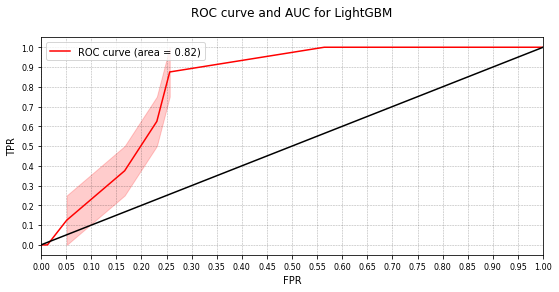

In [142]:
plot_roc_auc(GRID_LGB.best_estimator_, 'LightGBM', 
             X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

In [143]:
pkl_filename = '../modeling/lgb.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(GRID_LGB.best_estimator_, file)

### 4. CatBoost

In [208]:
start = time.time()
print("Started at", str(time.ctime(int(start))))

cat_params = {'learning_rate': [0.01],
              'l2_leaf_reg': [1],
              'subsample': [1],
              'rsm' : [.75],
              'max_depth': [11], # up to 16 
              'grow_policy': ['Lossguide'],
              'min_data_in_leaf' : [11], 
              'max_leaves' : [11],
              'iterations' : [150]} 

cat = CatBoostClassifier(random_state = 20202020, verbose = 0,
                         eval_metric = 'AUC:hints=skip_train~false', objective = 'Logloss')

GRID_cat = GridSearchCV(cat, param_grid = cat_params, cv = 3, scoring = 'roc_auc', n_jobs = -1)
GRID_cat.fit(X_train_reduced.drop(['Team', 'games_played', 'season'], 1), y_train)

print("Ended at", str(time.ctime(int(time.time()))))
print(time.time() - start)

Started at Wed Sep 15 21:36:53 2021
Ended at Wed Sep 15 21:36:55 2021
1.2895090579986572


In [209]:
evaluate_model('CatBoost', GRID_cat.best_estimator_, 
                X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

Accuracy for CatBoost : 0.951
AUC for CatBoost : 0.8654
LogLoss for CatBoost : 0.249


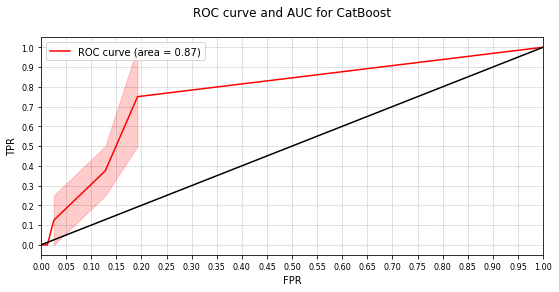

In [210]:
plot_roc_auc(GRID_cat.best_estimator_, 'CatBoost', 
             X_test_reduced.drop(['Team', 'games_played', 'season'], 1), y_test)

In [211]:
pkl_filename = '../modeling/catboost.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(GRID_cat.best_estimator_, file)

### See if any sort of stacking helps prediction accuracy

In [212]:
pred_rf = GRID_RF_reduced.best_estimator_.predict_proba(X_test_reduced.drop(['Team', 'games_played', 'season'], 1))[:,1]
pred_gbm = GRID_GBM.best_estimator_.predict_proba(X_test_reduced.drop(['Team', 'games_played', 'season'], 1))[:,1]
pred_lgb = GRID_LGB.best_estimator_.predict_proba(X_test_reduced.drop(['Team', 'games_played', 'season'], 1))[:,1]
pred_catboost = GRID_cat.best_estimator_.predict_proba(X_test_reduced.drop(['Team', 'games_played', 'season'], 1))[:,1]

In [215]:
mean_pred = (0.5 * pred_rf + 2 * pred_gbm + 0.5 * pred_lgb + 3 * pred_catboost) / 6

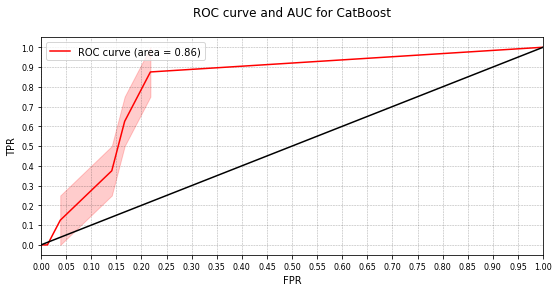

In [216]:
plot_roc_auc_without_model('CatBoost', mean_pred, y_test)